In [8]:
%reload_ext autoreload
%reload_ext autoreload

In [9]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
from functools import partial
# warnings.filterwarnings('ignore')

In [10]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

/home/geshi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import numpy as np
import scipy
import seaborn as sns

from tqdm.notebook import tqdm, trange

In [12]:
sys.path.append("../")

In [13]:
from chaosmining.data_utils import read_formulas, create_simulation_data
from chaosmining.simulation.models import MLPRegressor
from chaosmining.simulation.functions import abs_argmax_topk
from chaosmining.utils import radar_factory

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [15]:
from captum.attr import IntegratedGradients, Saliency, DeepLift, FeatureAblation

In [16]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [4, 4]

# Generate Functions and Data

In [17]:
formulas_path = '../data/symbolic_simulation/formula.csv'

In [18]:
formulas = read_formulas(formulas_path)

In [19]:
formula_id = 14
seed = 9999
test_size = 0.2
n_steps = 20

In [20]:
num_features, function = formulas[formula_id]

In [21]:
num_noises = 200
num_data = 10000
X_var = 0.33
y_var = 0.01
X, y_true, y_noise, intercepts, derivatives, integrations = create_simulation_data(function, num_features, num_noises, num_data, X_var, y_var, n_steps=n_steps)
print('X', X.shape, 'y true', y_true.shape, 'y noise', y_noise.shape, 
      'intercepts', len(intercepts), intercepts[0].shape,
      'derivatives', len(derivatives), derivatives[0].shape, 
      'integrations', len(integrations), integrations[0].shape)

X (10000, 210) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)


In [22]:
intercepts = np.stack(intercepts, axis=1)
derivatives = np.stack(derivatives, axis=1)
integrations = np.stack(integrations, axis=1)

In [23]:
y = y_true + y_noise

In [24]:
X_train, X_test, \
y_train, y_test, \
y_true_train, y_true_test, \
intercepts_train, intercepts_test, \
derivatives_train, derivatives_test, \
integrations_train, integrations_test \
= train_test_split(X, y, y_true, intercepts, derivatives, integrations, test_size=test_size, random_state=seed)

# Training and Test a MLP

In [25]:
train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
train_loader = DataLoader(train_set, batch_size=y_train.shape[0], shuffle=True)
test_set = TensorDataset(Tensor(X_test), Tensor(y_true_test))
test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

In [26]:
hidden_layer_sizes = (100,100,100)
num_epochs = 1000

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
model = MLPRegressor(num_features+num_noises, hidden_layer_sizes, p=0.0)
model.to(device)
model.train()

MLPRegressor(
  (blocks): ModuleList(
    (0): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=210, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (1): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (2): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (project): Linear(in_features=100, out_features=1, bias=True)
)

In [29]:
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), 0.001)

In [30]:
def train(model, dataloader, num_epochs, optimizer):
    pbar = trange(num_epochs, desc='Train', unit='epoch', initial=0, disable=True)
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # forward pass
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, targets)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        pbar.set_postfix(loss = '%.3f' % running_loss)
    print('train loss:', running_loss)

In [31]:
train(model, train_loader, num_epochs, optimizer)

train loss: 3.421951433324466e-08


In [32]:
y_pred = model(Tensor(X_test).to(device)).detach().cpu().numpy()

In [33]:
score = mean_absolute_error(y_pred, y_test)
print('Test mean absolute value is', score)

Test mean absolute value is 0.12837373070820485


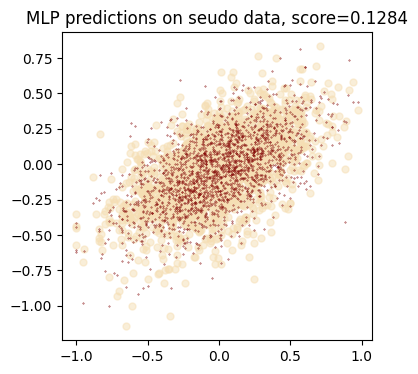

In [34]:
plt.scatter(X_test[:,0], y_test, c='wheat', alpha=0.5)
plt.scatter(X_test[:,0], y_pred, s=0.1, c='maroon', alpha=1)
plt.title(f"MLP predictions on seudo data, score={score:.4f}")
plt.show()

In [35]:
X_train.shape

(8000, 210)

# Iterative Method

In [63]:
reduce_rate = 0.8
best_score = 10
num_cur_features = num_features+num_noises
select_arr = np.ones(num_cur_features)
print(np.sum(select_arr))
remaining_inds = np.nonzero(select_arr)[0]

210.0


In [ ]:
while num_cur_features>0:
    bool_arr = np.array(select_arr, dtype='bool') 
    
    train_set = TensorDataset(Tensor(X_train[...,bool_arr]), Tensor(y_train))
    train_loader = DataLoader(train_set, batch_size=y_train.shape[0], shuffle=True)
    test_set = TensorDataset(Tensor(X_test[...,bool_arr]), Tensor(y_true_test))
    test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

    model = MLPRegressor(int(np.sum(select_arr)), hidden_layer_sizes, p=0.0)
    model.to(device)
    model.train()

    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), 0.001)

    train(model, train_loader, num_epochs, optimizer)

    model.eval()
    y_pred = model(Tensor(X_test[...,bool_arr]).to(device)).detach().cpu().numpy()
    score = mean_absolute_error(y_pred, y_test)
    print('score', score)

    if score > best_score:
        break
    else:
        best_score = score

    xai = Saliency(model)
    # xai = DeepLift(model)
    # xai = FeatureAblation(model)
    # xai = IntegratedGradients(model)

    num_remove = int(num_cur_features*(1-reduce_rate))
    if num_remove<1:
        break
    print('num_remove', num_remove)
    
    xai_attr_test = xai.attribute(Tensor(X_test[...,bool_arr]).to(device))
    abs_xai_attr_test = np.abs(xai_attr_test.detach().cpu().numpy()).mean(0)
    
    inds = np.argpartition(abs_xai_attr_test, num_remove)[:num_remove]
    inds_to_remove = remaining_inds[inds]
    select_arr[inds_to_remove] = 0
    
    remaining_inds = np.nonzero(select_arr)[0]
    num_cur_features -= num_remove
    print('remaining', len(remaining_inds), num_cur_features)

train loss: 6.305120905381045e-07
score 0.13150682077520043
num_remove 41
remaining 169 169


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 1.633257738831162e-06
score 0.12732308762732603
num_remove 33
remaining 136 136


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 7.054972957121208e-05
score 0.09991432813567223
num_remove 27
remaining 109 109


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0003095513384323567
score 0.08100960945830551
num_remove 21
remaining 88 88


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0006408251938410103
score 0.06429843693746574
num_remove 17
remaining 71 71


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0009540521423332393
score 0.05539399330549304
num_remove 14
remaining 57 57


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0011874204501509666
score 0.050428855912676034
num_remove 11
remaining 46 46


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0014971575001254678
score 0.04456760075331033
num_remove 9
remaining 37 37


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.001275622402317822
score 0.03603295500862785
num_remove 7
remaining 30 30


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0004235644591972232
score 0.0181890832752457
num_remove 5
remaining 25 25


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0004449910775292665
score 0.017785574226152085
num_remove 4
remaining 21 21


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [ ]:
print('The best score is:', best_score)
print('best features:', np.where(select_arr==1)[0])